#**Load the data using the pandas library.**


---



*   Check which columns have missing values.
*   Clean the data:
    1. Remove duplicate rows.

    2. Fill missing values using the median of each column.

    3. If current or voltage columns have negative values, convert them to positive.

In [4]:
import pandas as pd
import numpy as np

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train columns:", train.columns.tolist())
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

for col in num_cols:
    median = train[col].median()
    train[col].fillna(median, inplace=True)
    if col in test.columns:
        test[col].fillna(median, inplace=True)

for col in cat_cols:
    mode = train[col].mode()[0]
    train[col].fillna(mode, inplace=True)
    if col in test.columns:
        test[col].fillna(mode, inplace=True)

train.drop_duplicates(inplace=True)

train = train[(train['soiling_ratio'] >= 0) & (train['soiling_ratio'] <= 1)]
if 'soiling_ratio' in test.columns:
    test['soiling_ratio'] = test['soiling_ratio'].clip(0, 1)

train = train[train['panel_age'] >= 0]
if 'panel_age' in test.columns:
    test['panel_age'] = test['panel_age'].clip(lower=0)

train = train[(train['voltage'] > 0) & (train['current'] > 0)]
if 'voltage' in test.columns:
    test['voltage'] = test['voltage'].clip(lower=0.01)
if 'current' in test.columns:
    test['current'] = test['current'].clip(lower=0.01)

train.reset_index(drop=True, inplace=True)

print("Cleaned train shape:", train.shape)
print("Cleaned test shape:", test.shape)
print("Any missing values in train:\n", train.isnull().sum())
print("Any missing values in test:\n", test.isnull().sum())



Train shape: (20000, 17)
Test shape: (12000, 16)
Train columns: ['id', 'temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count', 'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure', 'string_id', 'error_code', 'installation_type', 'efficiency']
Missing values in train:
 id                       0
temperature           1001
irradiance             987
humidity                 0
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed               0
pressure                 0
string_id                0
error_code            5912
installation_type     5028
efficiency               0
dtype: int64
Missing values in test:
 id                       0
temperature            582
irradiance             615
humidity                 0
panel_age              607
maintenance_count      609
so

<ipython-input-4-3d6b02669954>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median, inplace=True)
<ipython-input-4-3d6b02669954>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

# **Visualize for the Given features**

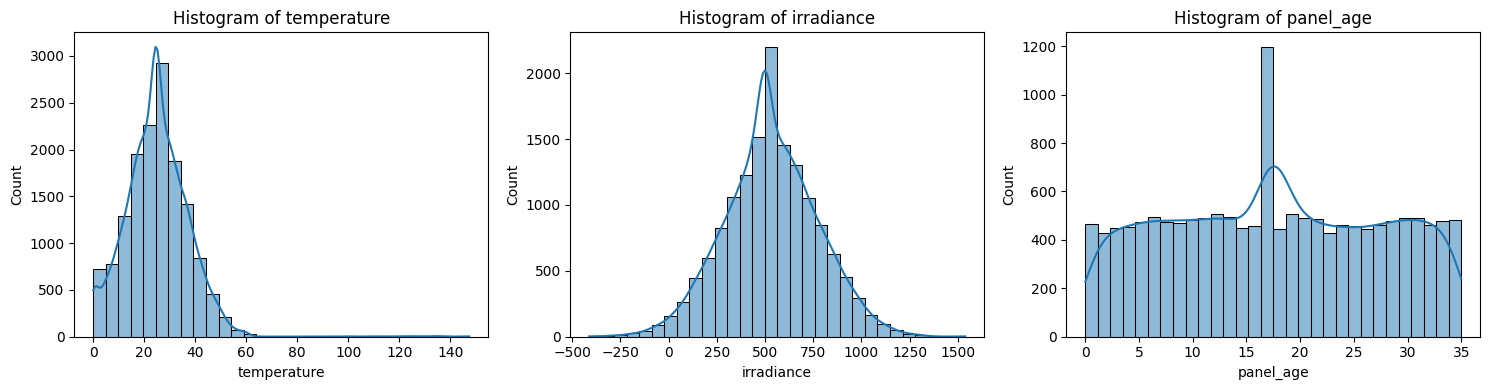

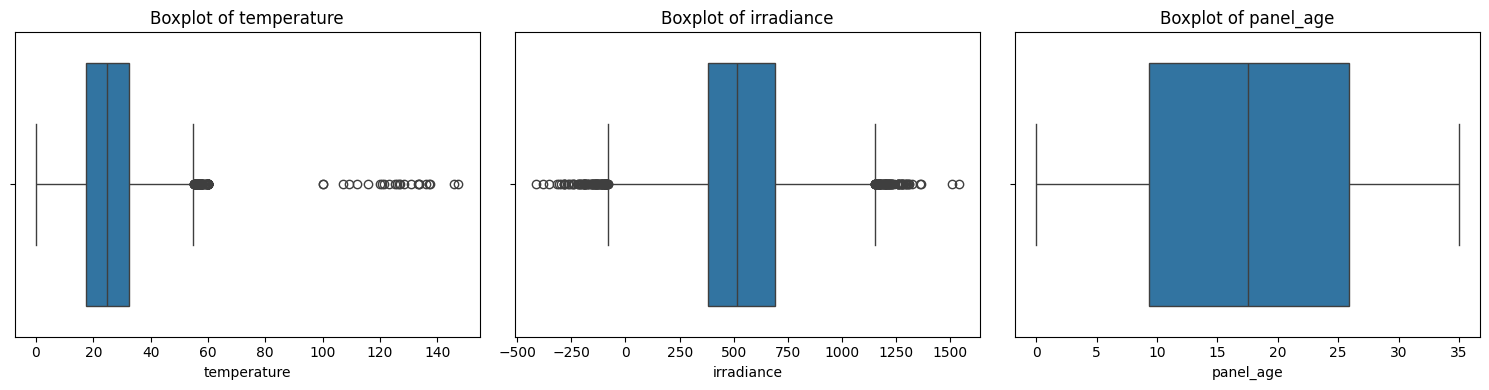

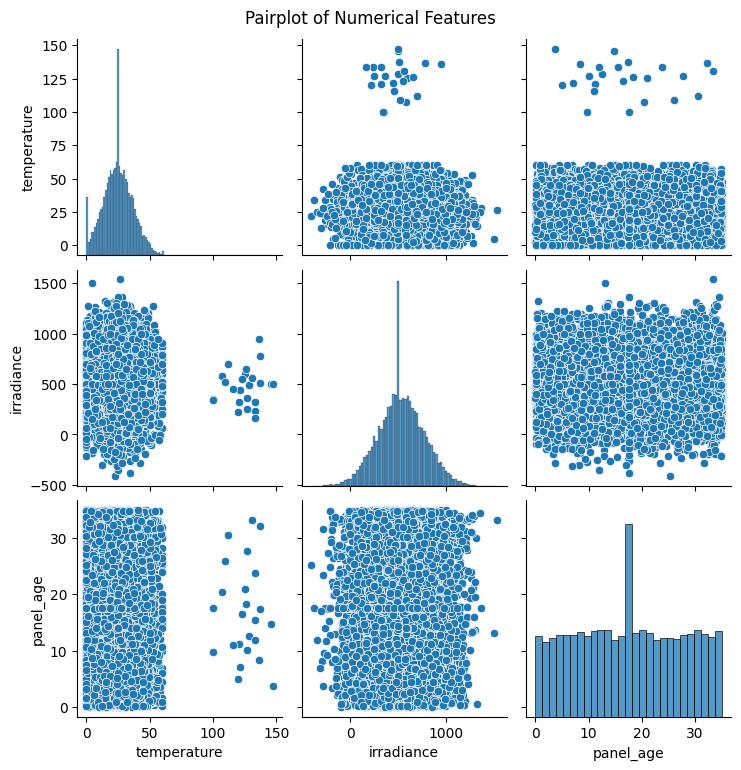

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['temperature', 'irradiance', 'panel_age']

plt.figure(figsize=(15, 4))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(train[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=train[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

sns.pairplot(train[numerical_features])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()


#**Detect Skewness, Outlier and Anomalies**

---



**Skewness** : Deviation from the median

---


**Outlier Detection** : Using IQR method ->
                        Q1: 25th percentile of the data.
                        
                        Q3: 75th percentile of the data.

                        IQR: Difference between Q3 and Q1.

                        Outlier: Q3 + 1.5 × IQR

---
**Anomaly Detection** : Using (3 x IQR) method -> similar to the previous one but uses a wider threshold (3×IQR) to detect extreme anomalies


In [8]:
import pandas as pd
import numpy as np

for col in numerical_features:
    train[col] = pd.to_numeric(train[col], errors='coerce')

print("Skewness for each feature:")
for col in numerical_features:
    skew = train[col].skew()
    print(f"{col}: {skew:.3f}")

def find_outliers_IQR(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

print("\nNumber of outliers detected (IQR method):")
for col in numerical_features:
    outliers = find_outliers_IQR(train[col])
    print(f"{col}: {len(outliers)}")

def find_extreme_anomalies(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    extreme = series[(series < lower_bound) | (series > upper_bound)]
    return extreme

print("\nNumber of extreme anomalies (beyond 3*IQR):")
for col in numerical_features:
    extreme = find_extreme_anomalies(train[col])
    print(f"{col}: {len(extreme)}")


Skewness for each feature:
temperature: 0.981
irradiance: 0.013
panel_age: 0.008

Number of outliers detected (IQR method):
temperature: 106
irradiance: 180
panel_age: 0

Number of extreme anomalies (beyond 3*IQR):
temperature: 24
irradiance: 0
panel_age: 0


#**Feature Engineering**

```
* Engineered new features: `power_output`, `maintenance_frequency`, and `temp_diff`.
* Handled categorical data using "Label Encoding" (for ≤5 unique values) and One-Hot Encoding(for >5).
* Filtered numeric data and verified presence of the target (`efficiency`).
* Analyzed and visualized "feature correlation" with `efficiency` using a heatmap.


```




Top Correlated Features with Target:
efficiency               1.000000
irradiance               0.559626
soiling_ratio            0.299803
current                  0.259443
power_output             0.226272
voltage                  0.111324
string_id                0.014437
maintenance_count        0.014347
installation_type        0.010762
maintenance_frequency    0.007850
id                      -0.004737
error_code              -0.008831
temp_diff               -0.010571
cloud_coverage          -0.014177
temperature             -0.034947
module_temperature      -0.041458
panel_age               -0.184966
Name: efficiency, dtype: float64


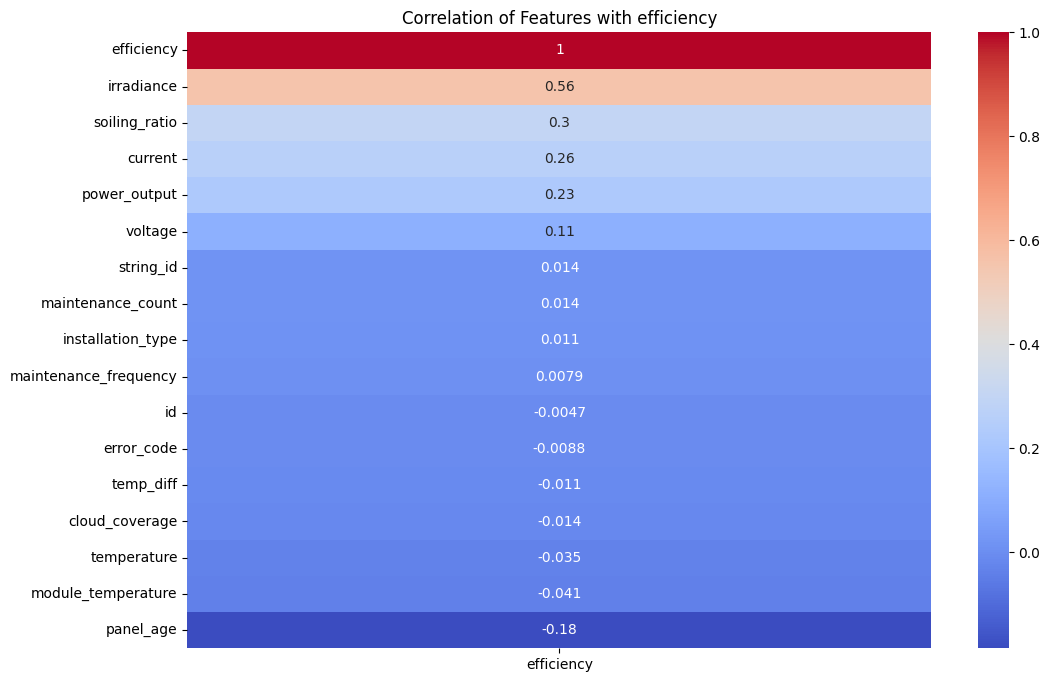

In [9]:

train['power_output'] = train['voltage'] * train['current']

train['maintenance_frequency'] = train['maintenance_count'] / (train['panel_age'].replace(0, np.nan))
train['maintenance_frequency'] = train['maintenance_frequency'].fillna(0)  # fixed warning

train['temp_diff'] = train['module_temperature'] - train['temperature']

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['installation_type', 'string_id', 'error_code']

for col in categorical_cols:
    if train[col].nunique() <= 5:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
    else:
        train = pd.get_dummies(train, columns=[col], prefix=col)

numeric_train = train.select_dtypes(include=[np.number])

if 'efficiency' in numeric_train.columns:
    target = 'efficiency'
else:
    raise ValueError("Target column 'efficiency' not found in numeric data.")

corr_matrix = numeric_train.corr()

top_corr = corr_matrix[target].sort_values(ascending=False)
print("\nTop Correlated Features with Target:")
print(top_corr)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[[target]].sort_values(by=target, ascending=False), annot=True, cmap='coolwarm')
plt.title(f'Correlation of Features with {target}')
plt.show()


# **Why Random Forest is an Option?**

---


```


*   It understands complicated patterns between things like voltage, current, and efficiency.
*   It works well even if the data has mistakes or unusual values.
*   It can use both numbers and categories (like installation type).
*   It shows which features are most important for prediction.
*   It’s less likely to make wrong predictions by overfitting.
*   It’s fast and reliable, even with lots of data.


```





Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0584
Mean Squared Error (MSE): 0.0116
Root Mean Squared Error (RMSE): 0.1078
R² Score: 0.4185


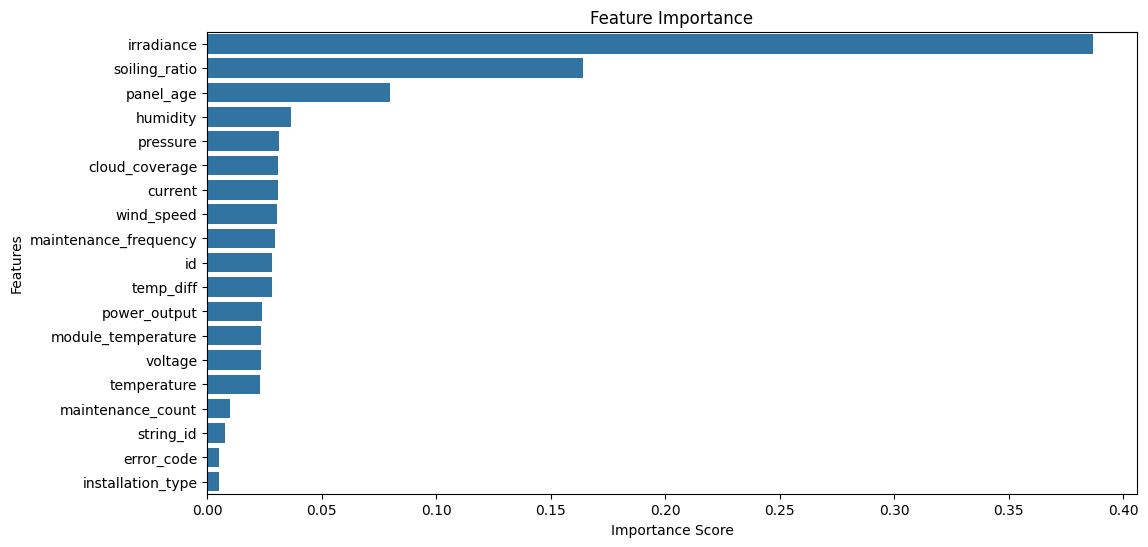

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = 'efficiency'

if target not in train.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

X = train.drop(columns=[target])
y = train[target]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

feature_importance = pd.Series(model.feature_importances_, index=train.drop(columns=[target]).columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


# **Why XGBBoost is an Option?**


---


```
*   It gives very high accuracy by learning from its mistakes step by step.
*   Works great with big and complex data (like solar panel readings).
*   Faster and more efficient than many other models.
*   Can handle missing values automatically.
*   Learns patterns better by focusing on the hard-to-predict parts.
*   Also tells you which features are most important.

```




Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0566
Mean Squared Error (MSE): 0.0116
Root Mean Squared Error (RMSE): 0.1079
R² Score: 0.4169


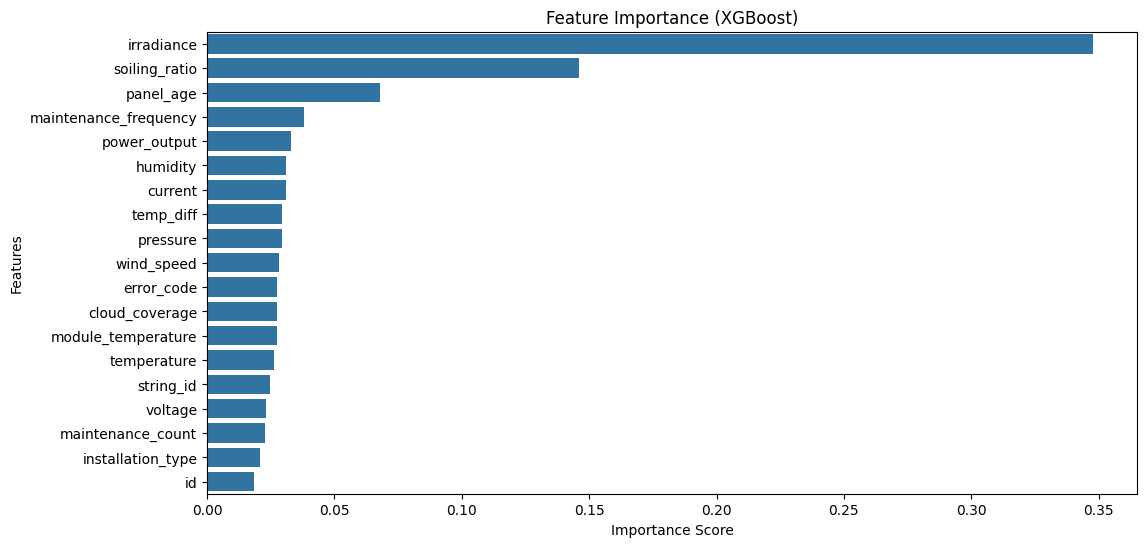

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = 'efficiency'

if target not in train.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

X = train.drop(columns=[target])
y = train[target]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


feature_importance = pd.Series(model.feature_importances_, index=train.drop(columns=[target]).columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


# **Why Neural Networks is an Option?**

---
```
*   They can learn very complex and hidden patterns in data.
*   Work well when there are lots of features and non-linear relationships.
*   Can improve accuracy by learning multiple layers of information.
*   Flexible and can be adapted for different kinds of data (images, time-series, etc.).
```




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3470 - mae: 0.3971 - val_loss: 0.0194 - val_mae: 0.0930
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0338 - mae: 0.1325 - val_loss: 0.0169 - val_mae: 0.0768
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0214 - mae: 0.1010 - val_loss: 0.0132 - val_mae: 0.0685
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0178 - mae: 0.0841 - val_loss: 0.0126 - val_mae: 0.0656
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0148 - mae: 0.0757 - val_loss: 0.0122 - val_mae: 0.0607
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0126 - mae: 0.0690 - val_loss: 0.0123 - val_mae: 0.0630
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0134 - mae: 0.0682 - val_loss: 0.0118 - val_mae: 0.0574
Epoch 8/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0125 - mae: 0.0655 - val_loss: 0.0118 - val_mae: 0.0587
Epoch 9/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - lo

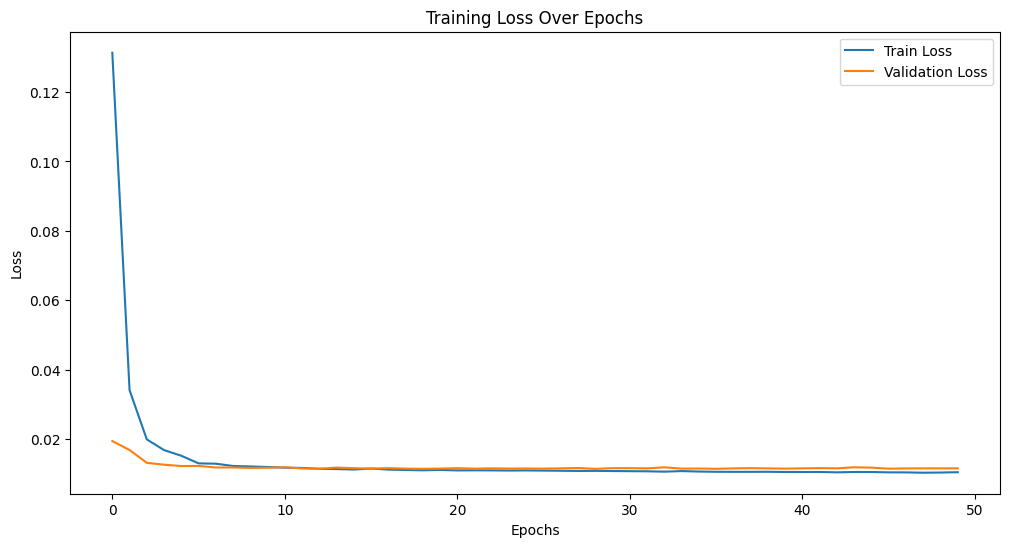

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = 'efficiency'

if target not in train.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

X = train.drop(columns=[target])
y = train[target]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


# **Comparision in between Models**

---
*Compare the models on the Basis of:*


1.   MAE: 0.0584
2.   RMSE: 0.1078
3.   R² Score:




93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


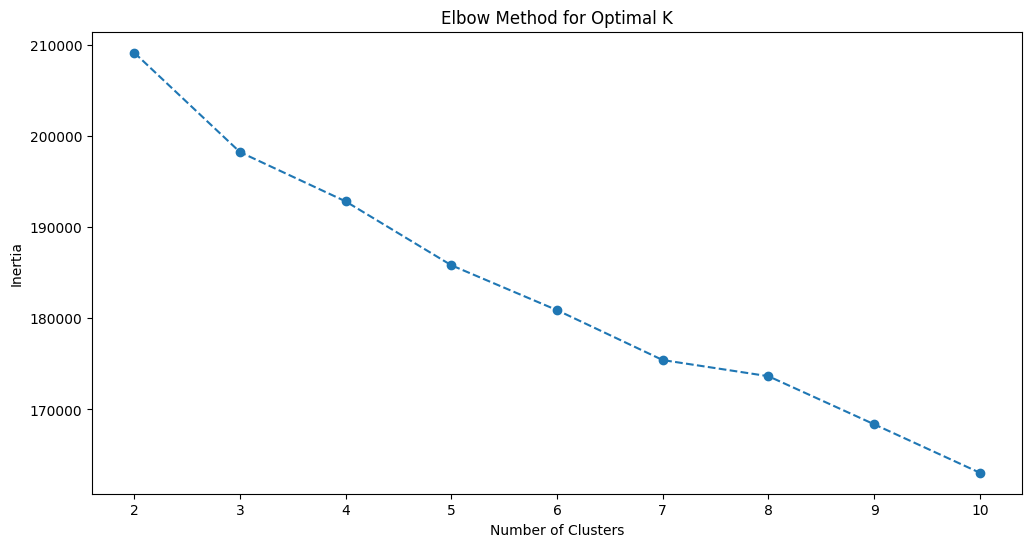

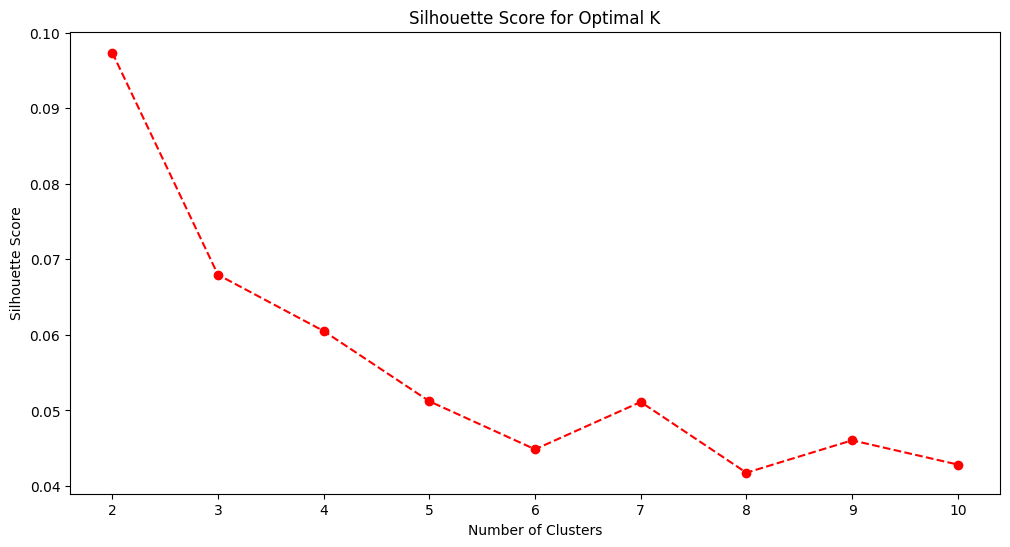

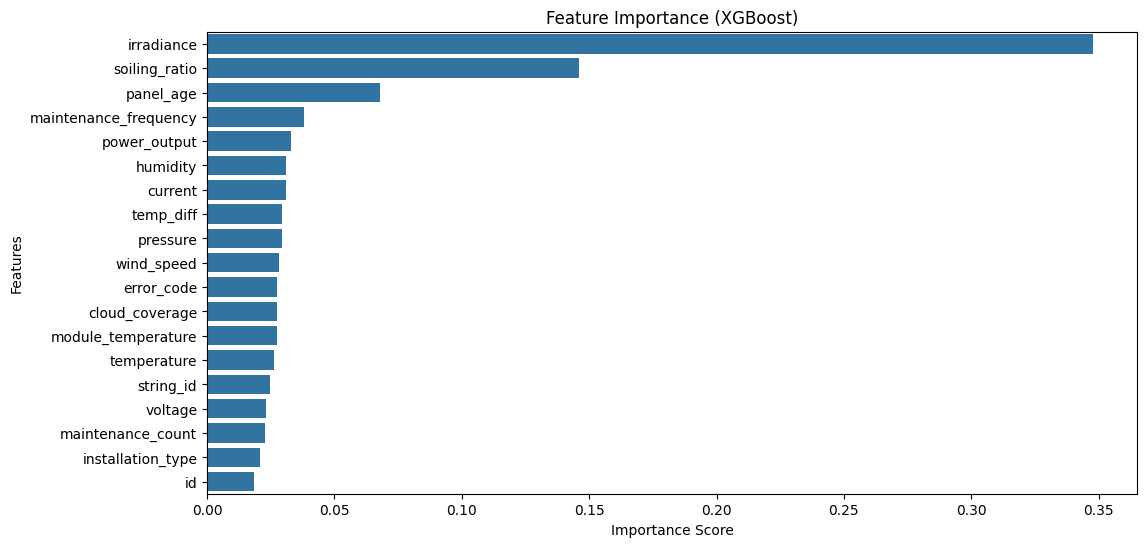


Model Performance Comparison:

Random Forest:
MAE: 0.0584
RMSE: 0.1078
R² Score: 0.4185

XGBoost:
MAE: 0.0566
RMSE: 0.1079
R² Score: 0.4169

Neural Network:
MAE: 0.0609
RMSE: 0.1089
R² Score: 0.4064


In [14]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

target = 'efficiency'
if target not in train.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

X = train.drop(columns=[target])
y = train[target]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}

nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
results["Neural Network"] = {"MAE": mae_nn, "RMSE": rmse_nn, "R² Score": r2_nn}

inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
X_clustered = kmeans.fit_predict(X_train)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

print("\nModel Performance Comparison:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# **SPLIT THE DATA**:

---


1.   Make sure the target column efficiency is in the data.
2.   Separate features and target.
3.   Change text columns to numbers (if possible).
4.   Fill missing values with the middle value (median).
5.   Split data into training and testing parts.
Scale features so they have similar ranges for better model training.




In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'efficiency'

if target not in train.columns:
    raise ValueError(f"Target column '{target}' not found in dataset.")

X = train.drop(columns=[target])
y = train[target]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X.fillna(X.median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **TRAIN THE MODEL** - XGBoost

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0566
Mean Squared Error (MSE): 0.0116
Root Mean Squared Error (RMSE): 0.1079
R² Score: 0.4169


# **Tune Hyperparameters**:

---
1.  Tries different settings for the XGBoost model to find the best ones.
2.  Uses a method that tests each setting and picks the best based on how well it works.
3.  Trains the model again with the best settings.
4.  Checks how good the new model is by predicting on test data.
5.  Shows scores that tell how accurate the model is.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)

best_model = XGBRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nTuned Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_best:.4f}")
print(f"Mean Squared Error (MSE): {mse_best:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best:.4f}")
print(f"R² Score: {r2_best:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


# **Final Test Data Processing & Prediction Pipeline**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

test = pd.read_csv("/content/test.csv")

for col in test.select_dtypes(include=['object']).columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

test.fillna(test.median(), inplace=True)

test['power_output'] = test['voltage'] * test['current']

if 'maintenance_count' in test.columns and 'panel_age' in test.columns:
    test['maintenance_frequency'] = test['maintenance_count'] / test['panel_age'].replace(0, np.nan)
    test['maintenance_frequency'].fillna(0, inplace=True)

if 'module_temperature' in test.columns and 'temperature' in test.columns:
    test['temp_diff'] = test['module_temperature'] - test['temperature']

missing_cols = set(X.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

X_test = scaler.transform(test[X.columns])

y_pred_test = best_model.predict(X_test)

submission = pd.DataFrame({
    "id": test.index,
    "efficiency": y_pred_test
})

submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")


In [ ]:
# Load the submission file
submission = pd.read_csv("/submission.csv")

# Ask the user for an ID input
input_id = input("Enter the ID to get predicted efficiency: ")

# Try to convert to integer (or float, if your IDs are not integers)
try:
    input_id = int(input_id)
except ValueError:
    print("Invalid ID format. Please enter a valid numeric ID.")
    exit()

# Find and display the efficiency for the given ID
if input_id in submission['id'].values:
    efficiency_value = submission.loc[submission['id'] == input_id, 'efficiency'].values[0]
    print(f"Predicted efficiency for ID {input_id}: {efficiency_value:.4f}")
else:
    print(f"No prediction found for ID {input_id}.")


NameError: name 'pd' is not defined